# Quantum Mechanics of an Electron in an Electromagnetic Field

In this notebook, we will study the energy levels and wavefunctions of an electron in an electromagnetic field. We make the following simplifying assumptions:

* The problem is two-dimensional and static: the electron moves in the $x$-$y$ plane, and the potentials can vary in $x$ and $y$ but have no $z$ or $t$ dependence.
* The electron is non-relativistic.
* $e = m = \hbar = 1$.

For this system, the time-independent Schrödinger wave equation takes the following partial differential equation (PDE) form:

$$\left\{\frac{1}{2}\left[\left(-i\frac{\partial}{\partial x} + A_x\right)^2 + \left(-i\frac{\partial}{\partial y} + A_y\right)^2\right] - \Phi(x,y) \right\} \psi(x,y) = E \;\psi(x,y)$$

where:

* $\Phi(x,y)$ is the electromagnetic scalar potential
* $A_x(x,y)$ and $A_y(x,y)$ are the $x$ and $y$ components of the vector potential
* $\psi(x,y)$ is an energy eigenfunction, and $E$ is the corresponding energy

## Numerical solver

A numerical solver for this PDE has been written for you below. The details are beyond the scope of this discussion, and are not required for the exercises below. (It uses a technique called the [finite difference method](https://en.wikipedia.org/wiki/Finite_difference_method), in which space is discretized into a grid and Taylor expansions are used to convert a PDE into a matrix equation.)

Skim through the code below. **There's no need to go through it in detail.** Then run the code cell and continue to the subsequent discussion.

In [1]:
%matplotlib inline

## Numerical solver for Schrodinger equation for electron in 2D
## See below for detailed documentation and usage examples.
##   Phi, Ax, Ay : functions specifying scalar and vector potential
##   args        : tuple of additional inputs to the potential functions
##   L           : length of computational domain
##   N           : no. of grid points in each direction (x and y)
##   num         : no. of solutions to find
##   E0          : approximate energy of solutions to find

def schrodinger2d(Phi, Ax, Ay, args=(), L=1.0, N=100, num=12, E0=-100.0):
    from numpy import linspace, meshgrid, reshape, exp, argsort
    from scipy.sparse import diags
    from scipy.sparse.linalg import eigsh

    a = L/(N+1)                                    # lattice spacing
    p = linspace(-L/2+a, L/2-a, N)
    xvec, yvec = meshgrid(p, p)                    # 2D grid
    x = reshape(xvec, N*N)                         # 1D array of x
    y = reshape(yvec, N*N)                         # 1D array of y

    ## Compute contents of the Hamiltonian matrix:
    Hd = 2/a**2 - Phi(x, y, *args)                 # diagonal terms
    ox = -0.5/a**2 * exp(1j*a*Ax(x+a/2, y, *args)) # x-step
    ox[(N-1)::N] = 0.0; ox = ox[:-1]               # Dirichlet BCs in x
    oy = -0.5/a**2 * exp(1j*a*Ay(x, y+a/2, *args)) # y-step
    oy = oy[:-N]                                   # Dirichlet BCs in y

    ## Construct the Hamiltonian matrix and solve it:
    H   = diags([Hd, ox, ox.conj(), oy, oy.conj()], [0, 1, -1, N, -N], format='csc', dtype=complex)
    E, psi = eigsh(H, num, sigma=E0, return_eigenvectors=True)
    idx = argsort(E)                               # sort in increasing E
    E   = E[idx]
    psi = reshape(psi[:,idx], (N, N, num))
    
    ## Grid coordinates suitable for `pcolormesh`
    pgrid = linspace(-L/2, L/2, N+1)
    x, y = meshgrid(pgrid, pgrid)
    return E, psi, x, y

### Inputs and outputs of the `schrodinger2d` function

The inputs to the `schrodinger2d` function that you need to be concerned with are `Phi`, `Ax`, `Ay`, and `args`.

#### Helper functions

For `Phi`, `Ax`, and `Ay`, the caller supplies **helper functions**.  These helper funcitons are responsible for computing the scalar and vector potentials. For `args`, the caller supplies a tuple, containing additional parameters (if any) to give the helper functions.

Each helper function should be a Python function that takes inputs `(x, y, ...)`, where `x` and `y` are arrays of $x$ and $y$ coordinates, and the other inputs, denoted by `...`, are the parameters specified in `args`. The helper function must return an array, of the same shape as $x$ and $y$, giving the potential at the specified points.

#### Other inputs

The other inputs to `schrodinger2d` can usually be omitted (i.e., left to their default values). These defaults specify a square computational cell of length `L=1.0`, with `N=50` grid points in each direction. The coordinate origin, $x = y = 0$, is the center of the box. Dirichlet boundary conditions are imposed at the walls of the box. The solver finds the `num=30` energy eigenstates whose energies are closest to `E0=-100.0` (if the eigenenergies are all positive, this setting finds the 30 lowest-energy solutions).

#### Return values

The `schrodinger2d` function returns three values:

* `E` is an array of energy eigenvalues located by the numerical solver, sorted in increasing order.
* `psi` is an array containing the corresponding wavefunctions, such that `psi[:,:,n]` is a 2D array specifying the grid values of the `n`-th wavefunction.
* `xgrid` and `ygrid` are 2D arrays specifying the $x$ and $y$ grid coordinates, suitable for passing to [`pcolormesh`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.pcolormesh.html).

## Example: 2D harmonic oscillator

Consider the following potentials:

$$\begin{aligned} \Phi &= - \frac{1}{2} \left(\omega_1^2 x^2 + \omega_2^2 y^2\right) \\ A_x &= A_y = 0.\end{aligned}$$

This describes a 2D harmonic oscillator with different spring constants in the $x$ and $y$ direction.  The energy spectrum should be

$$E_{mn} = \hbar \omega_1 \left(m + \frac{1}{2}\right) + \hbar \omega_2 \left(n + \frac{1}{2}\right), \;\; m, n \in \mathbb{Z}.$$

We implement these potentials by writing the following helper functions:

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Return the electromagnetic scalar potential for a 2D harmonic oscillator,
## evaluated at 2D coordinates x and y (where x and y may be 2D arrays).
def Phi_2dwell(x, y, omega1, omega2):
    return - 0.5 * (omega1**2 * x**2 + omega2**2 * y**2)

# Return an array of zeros with the same array shape as x.
def zerofield(x, y, omega1, omega_2): 
    return np.zeros(x.shape)

Now let's check whether the numerical solver gives the expected spectrum:

Text(0, 0.5, 'E')

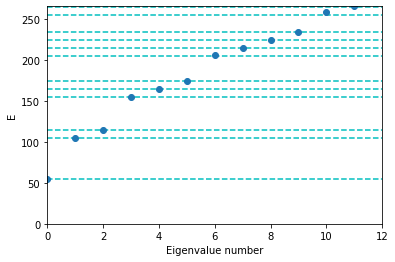

In [3]:
omega1, omega2 = 50.0, 60.0   # Values of the omega1 and omega2 parameters

## Look carefully at show `schrodinger2d' is called.
E, psi, x, y = schrodinger2d(Phi_2dwell, zerofield, zerofield, (omega1, omega2))

## Plot the energy levels, and compare to the theoretical values.
nstates = len(E)
for m in range(5):
    for n in range(5):
        Eth = omega1*(m+0.5) + omega2*(n+0.5)
        plt.plot([0, nstates], [Eth, Eth], 'c--')
        
plt.plot(E, 'o')
plt.xlim(0, nstates); plt.ylim(0, E[-1])
plt.xlabel('Eigenvalue number')
plt.ylabel('E')

From the plot produced by the above code, you should see that the numerically obtained eigenenergies (plotted as dots) accurately matches the theoretical predictions (plotted as horizontal dashes).

We can also inspect the spatial distributions of the eigenstates:

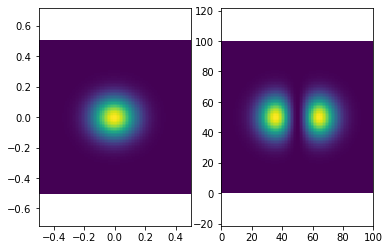

In [4]:
plt.subplot(1, 2, 1)
plt.axis("equal")
plt.pcolor(x, y, abs(psi[:,:,0])**2)

plt.subplot(1, 2, 2)
plt.axis("equal")
plt.pcolormesh(abs(psi[:,:,1])**2)

## Task 1: Electron in a uniform magnetic field (8 marks)

Now consider scalar and vector potentials of the form

$$\begin{aligned} \Phi &= - \frac{1}{2} \omega_0^2 (x^2 + y^2) \\ A_x &= - B_0 y \\ A_y &= 0. \end{aligned}$$

The scalar potential acts as quadratic potential well, similar to the previous example except that it is isotropic. The vector potential generates a uniform out-of-plane magnetic field $\vec{B} = [0, 0, B_0]$ (you can verify this by calculating $\nabla \times \vec{A}$).

Investigate:
* The energy spectrum of the system for different values of $\omega_0$ and $B_0$ (you should look at "large" and "small" values of both parameters).
* How the energy eigenfunctions are spatially distributed.

Your answer should consist of text descriptions, accompanied by code to generate the plots supporting your findings.

# Task 2: Gauge invariance (4 marks)

Take the scalar and vector potentials from Task 1, with the parameters fixed at, say, $\omega_0 = 100, B_0 = 1.0$ (you may use different parameters, if you wish).  Now consider the gauge field

$$\lambda(x,y) = ax + by,$$

where $a$ and $b$ are arbitrary constants. Demonstrate, numerically, that the different choices of $a$ and $b$ do not affect the energy eigenvalues, nor the energy eigenfunctions' probability densities.

It is up to you to choose exactly what plots to generate to demonstrate this phenomenon.

# Task 3: The Aharonov-Bohm Effect (8 marks)

Consider the following scalar potential:

$$\Phi = - V_0 \left\{2 - \tanh\left[\frac{r-R_1}{d}\right] + \tanh\left[\frac{r-R_2}{d}\right]\right\}$$

where $r = \sqrt{x^2+y^2}$. This scalar potential generates an annulus of inner radius $R_1$ and outer radius $R_2$.  Inside the annulus, the potential is $0$; outside, the potential is $-2V_0$.  The scalar potential is plotted below:

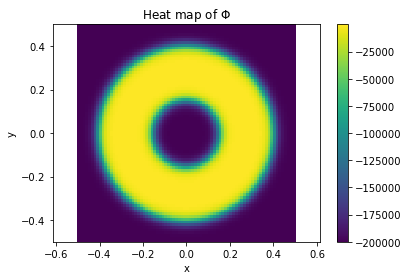

In [29]:
## Plot Phi for a particular choice of parameters:
V0, R1, R2, d = 1e5, 0.15, 0.4, 0.025

N      = 80
coords = np.linspace(-0.5+1./(N+1), 0.5-1./(N+1), N)
x, y   = np.meshgrid(coords, coords)
r      = np.sqrt(x**2 + y**2)
Phi    = - V0 * (2 - np.tanh((r-R1)/d) + np.tanh((r-R2)/d))

grid = np.linspace(-0.5, 0.5, N+1)
x, y = np.meshgrid(grid, grid)

plt.pcolormesh(x, y, Phi)
plt.axis("equal")
plt.title("Heat map of $\Phi$")
plt.xlabel("x"); plt.ylabel("y")
plt.colorbar()

Now consider the following vector potential:

$$\begin{aligned} A_x &= - \frac{\Phi_B}{2\pi r} \, \sin\phi \\ A_y &= \;\;\frac{\Phi_B}{2\pi r} \, \cos\phi. \end{aligned}$$

Here, $\phi$ is the usual azimuthal coordinate (which can be computed from $x$ and $y$ using the [`arctan2`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.arctan2.html) function). As previously discussed in class, this vector potential corresponds to an infinitesimally narrow region of magnetic flux $\Phi_B$ placed at the origin.

Investigate how the energy spectrum varies with $\Phi_B$, including the role of the magnetic flux quantum $h/e$ (which is equal to $2\pi$ in the present computational units where $\hbar = e = 1$). Provide text descriptions, accompanied by code to generate the plots supporting your findings.

# Task 4: Landau levels (10 marks)

According to the theory of Landau quantization, when an electron moving in infinite 2D space is subject to a uniform out-of-plane magnetic field of magnitude $B_0$, with zero electric field everywhere, the energy levels take the quantized values

$$E_n = \frac{\hbar eB}{m} \left(n+\frac{1}{2}\right), \;\;\; n = 0, 1, 2, \dots$$

However, if the electron is not allowed to range over the entire 2D space, but is instead confined to a finite region (e.g., the annular region from Task 3), the Landau theory supposedly continues to hold approximately, under the following conditions: (i) the scalar potential is approximately zero in the confinement region, and (ii) the "magnetic length"

$$\ell_b = \sqrt{\frac{\hbar}{eB}}$$

is much smaller than the size of the confinement region. Notably, this behavior is believed to be independent of the exact shape of the confinement region.

Investigate the validity of the above statements, including the conditions under which the Landau quantization breaks down. You are free to choose suitable $\Phi$, $A_x$, and $A_y$ potentials (just be sure to document/explain them).